In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 1. Imports
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.svm import OneClassSVM
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, matthews_corrcoef, precision_recall_curve
)
from sklearn.decomposition import PCA
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")





In [ ]:
# 2. Load Data (Kaggle Format)
data = pd.read_csv('/content/drive/MyDrive/ZIDIO/Month 2/creditcard.csv')


print(data.head(10))
print(data.tail(10))
print(data.info())
print(data.describe())

data.fillna(0, inplace=True)
data.drop_duplicates(inplace=True)

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   
5   2.0 -0.425966  0.960523  1.141109 -0.168252  0.420987 -0.029728  0.476201   
6   4.0  1.229658  0.141004  0.045371  1.202613  0.191881  0.272708 -0.005159   
7   7.0 -0.644269  1.417964  1.074380 -0.492199  0.948934  0.428118  1.120631   
8   7.0 -0.894286  0.286157 -0.113192 -0.271526  2.669599  3.721818  0.370145   
9   9.0 -0.338262  1.119593  1.044367 -0.222187  0.499361 -0.246761  0.651583   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -

In [ ]:
# 3. Feature Engineering
data['Amount_to_Mean'] = data['Amount'] / data['Amount'].mean()
data['Hour'] = (data['Time'] // 3600) % 24
X = data.drop(['Class', 'Time'], axis=1)
print(X)
y = data['Class']
print(y)

               V1         V2        V3        V4        V5        V6  \
0       -1.359807  -0.072781  2.536347  1.378155 -0.338321  0.462388   
1        1.191857   0.266151  0.166480  0.448154  0.060018 -0.082361   
2       -1.358354  -1.340163  1.773209  0.379780 -0.503198  1.800499   
3       -0.966272  -0.185226  1.792993 -0.863291 -0.010309  1.247203   
4       -1.158233   0.877737  1.548718  0.403034 -0.407193  0.095921   
...           ...        ...       ...       ...       ...       ...   
284802 -11.881118  10.071785 -9.834783 -2.066656 -5.364473 -2.606837   
284803  -0.732789  -0.055080  2.035030 -0.738589  0.868229  1.058415   
284804   1.919565  -0.301254 -3.249640 -0.557828  2.630515  3.031260   
284805  -0.240440   0.530483  0.702510  0.689799 -0.377961  0.623708   
284806  -0.533413  -0.189733  0.703337 -0.506271 -0.012546 -0.649617   

              V7        V8        V9       V10  ...       V22       V23  \
0       0.239599  0.098698  0.363787  0.090794  ...  0.27783

In [ ]:
# 4. Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(X_scaled)


[[-0.70108232 -0.04168726  1.68010106 ...  0.24419951  0.24419951
  -2.40721718]
 [ 0.60879165  0.16413764  0.10927902 ... -0.34258399 -0.34258399
  -2.40721718]
 [-0.7003364  -0.81133678  1.17426962 ...  1.15889967  1.15889967
  -2.40721718]
 ...
 [ 0.98235398 -0.18043304 -2.15503257 ... -0.0822395  -0.0822395
   1.53464456]
 [-0.12646526  0.32465977  0.46457662 ... -0.31339058 -0.31339058
   1.53464456]
 [-0.27686005 -0.1127094   0.46512487 ...  0.51329005  0.51329005
   1.53464456]]


In [ ]:

# 5. Train/Test Split & SMOTE
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
smote = SMOTE(sampling_strategy=0.1, random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
print("Train class balance after SMOTE:", Counter(y_train_bal))




Train class balance after SMOTE: Counter({0: 226602, 1: 22660})


In [ ]:
# 6. Evaluation Helper
def eval(model, X_test, y_test, model_name):
    y_proba = model.predict_proba(X_test)[:, 1]
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
    f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
    best_idx = np.argmax(f1s)
    best_thresh = thresholds[best_idx]
    y_pred = (y_proba >= best_thresh).astype(int)
    print(f"\n[{model_name}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")
    print(f"MCC: {matthews_corrcoef(y_test, y_pred):.4f}")



In [ ]:

# ------------ SUPERVISED MODELS ------------

# Logistic Regression
lr = LogisticRegression(
    max_iter=600,
    class_weight='balanced',
    C=0.5,
    solver='saga',
    random_state=42
)
lr.fit(X_train, y_train)
eval(lr, X_test, y_test, "Logistic Regression")

# Decision Tree
dt = DecisionTreeClassifier(
    max_depth=12,
    min_samples_leaf=10,
    class_weight='balanced',
    random_state=42
)
dt.fit(X_train_bal, y_train_bal)
eval(dt, X_test, y_test, "Decision Tree")

# Random Forest
rf = RandomForestClassifier(
    n_estimators=120,
    max_depth=10,
    min_samples_leaf=8,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_bal, y_train_bal)
eval(rf, X_test, y_test, "Random Forest")

# XGBoost
scale = (y_train == 0).sum() / (y_train == 1).sum()
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.02,
    scale_pos_weight=scale,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)
eval(xgb_model, X_test, y_test, "XGBoost")

# LightGBM
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    max_depth=6,
    class_weight='balanced',
    min_child_samples=20,
    subsample=0.8,
    random_state=42,
    n_jobs=-1
)
lgb_model.fit(X_train, y_train)
eval(lgb_model, X_test, y_test, "LightGBM")


[Logistic Regression
Confusion Matrix:
 [[56641    10]
 [   23    72]]
Accuracy: 0.9994
Precision: 0.8780
Recall: 0.7579
F1-Score: 0.8136
ROC-AUC: 0.9663
MCC: 0.8155

[Decision Tree
Confusion Matrix:
 [[56631    20]
 [   29    66]]
Accuracy: 0.9991
Precision: 0.7674
Recall: 0.6947
F1-Score: 0.7293
ROC-AUC: 0.8543
MCC: 0.7298

[Random Forest
Confusion Matrix:
 [[56638    13]
 [   22    73]]
Accuracy: 0.9994
Precision: 0.8488
Recall: 0.7684
F1-Score: 0.8066
ROC-AUC: 0.9764
MCC: 0.8073

[XGBoost
Confusion Matrix:
 [[56639    12]
 [   27    68]]
Accuracy: 0.9993
Precision: 0.8500
Recall: 0.7158
F1-Score: 0.7771
ROC-AUC: 0.9750
MCC: 0.7797
[LightGBM] [Info] Number of positive: 378, number of negative: 226602
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7675
[LightGBM] [Info] Number of data points in the train set: 226980, number of used features:

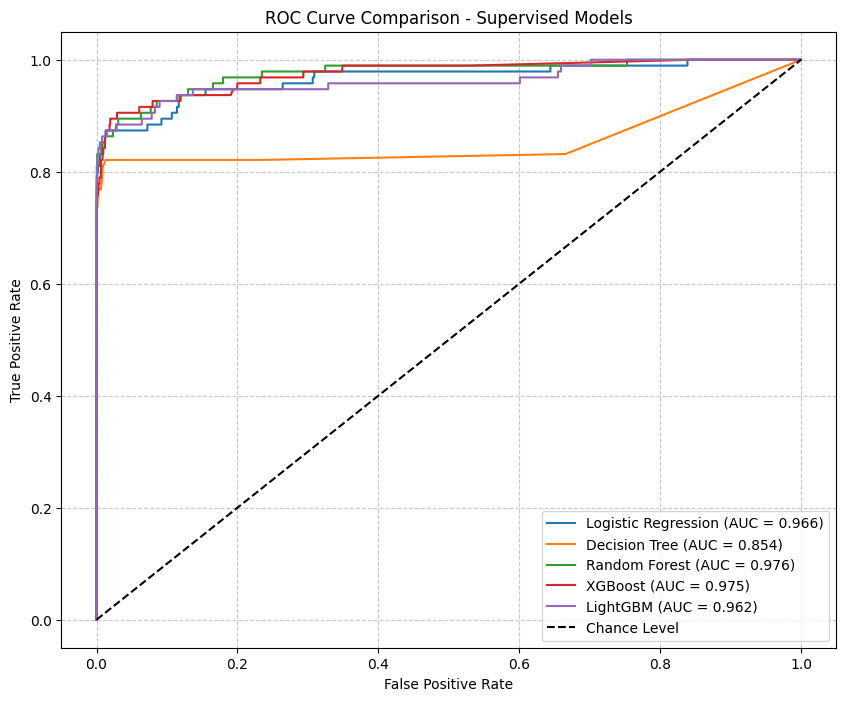

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

models = {
    "Logistic Regression": lr,
    "Decision Tree": dt,
    "Random Forest": rf,
    "XGBoost": xgb_model,
    "LightGBM": lgb_model
}

plt.figure(figsize=(10, 8))

for name, model in models.items():
    # Predict probabilities
    if hasattr(model, "predict_proba"):
        y_pred_prob = model.predict_proba(X_test)[:, 1]
    else:
        # For models without predict_proba
        y_pred_prob = model.decision_function(X_test)

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

# Plot baseline
plt.plot([0, 1], [0, 1], 'k--', label="Chance Level")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison - Supervised Models")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


In [ ]:

# ------------ UNSUPERVISED MODELS ------------

# Prepare MinMax data for unsupervised
scaler_mms = MinMaxScaler()
X_scaled_mms = scaler_mms.fit_transform(X)

# Isolation Forest (tuned)
iso = IsolationForest(
    n_estimators=200,
    contamination=0.0015,
    random_state=42
)
y_iso_pred = iso.fit_predict(X_scaled_mms)
y_iso_pred = np.where(y_iso_pred == -1, 1, 0)
print("\n[Isolation Forest]")
print("Confusion Matrix:\n", confusion_matrix(y, y_iso_pred))
print(f"Precision: {precision_score(y, y_iso_pred):.4f}")
print(f"Recall: {recall_score(y, y_iso_pred):.4f}")
print(f"F1-Score: {f1_score(y, y_iso_pred):.4f}")

# One-Class SVM (tuned)
pca = PCA(n_components=10, random_state=42)
X_pca = pca.fit_transform(X_scaled_mms)
ocsvm = OneClassSVM(
    nu=0.002,
    kernel='rbf',
    gamma='scale'
)
y_svm_pred = ocsvm.fit_predict(X_pca)
y_svm_pred = np.where(y_svm_pred == -1, 1, 0)
print("\n[One-Class SVM (PCA)]")
print("Confusion Matrix:\n", confusion_matrix(y, y_svm_pred))
print(f"Precision: {precision_score(y, y_svm_pred):.4f}")
print(f"Recall: {recall_score(y, y_svm_pred):.4f}")
print(f"F1-Score: {f1_score(y, y_svm_pred):.4f}")

# Autoencoder (tuned)
input_dim = X_scaled_mms.shape[1]
input_layer = Input(shape=(input_dim,))
encoder = Dense(32, activation="relu")(input_layer)
encoder = Dense(16, activation="relu")(encoder)
encoder = Dense(8, activation="relu")(encoder)
decoder = Dense(16, activation="relu")(encoder)
decoder = Dense(32, activation="relu")(decoder)
decoder = Dense(input_dim, activation="sigmoid")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

X_nonfraud = X_scaled_mms[y == 0]
autoencoder.fit(
    X_nonfraud, X_nonfraud,
    epochs=5,
    batch_size=128,
    shuffle=True,
    validation_split=0.08,
    callbacks=[early_stop],
    verbose=1
)

reconstructions = autoencoder.predict(X_scaled_mms)
mse = np.mean(np.power(X_scaled_mms - reconstructions, 2), axis=1)
prec, rec, thres = precision_recall_curve(y, mse)
f1s = 2 * (prec * rec) / (prec + rec + 1e-10)
best_idx = np.argmax(f1s)
best_thr = thres[best_idx]
y_ae_pred = (mse > best_thr).astype(int)
print(f"\n[Autoencoder, threshold={best_thr:.6f}]")
print("Confusion Matrix:\n", confusion_matrix(y, y_ae_pred))
print(f"Precision: {prec[best_idx]:.4f}")
print(f"Recall: {rec[best_idx]:.4f}")
print(f"F1-Score: {f1s[best_idx]:.4f}")



[Isolation Forest]
Confusion Matrix:
 [[282919    334]
 [   381     92]]
Precision: 0.2160
Recall: 0.1945
F1-Score: 0.2047

[One-Class SVM (PCA)]
Confusion Matrix:
 [[282779    474]
 [   366    107]]
Precision: 0.1842
Recall: 0.2262
F1-Score: 0.2030
Epoch 1/5
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0055 - val_loss: 0.0012
Epoch 2/5
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0011 - val_loss: 9.3780e-04
Epoch 3/5
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - loss: 8.8456e-04 - val_loss: 8.0050e-04
Epoch 4/5
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 7.7650e-04 - val_loss: 7.4647e-04
Epoch 5/5
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 6.6536e-04 - val_loss: 6.4419e-04
8867/8867 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step

[Autoencoder, threshold=0.009348]
Confusion Matrix:
 [[283031    222]
 [   236    237]]
Precision: 0.5174
Recall: 0.5032
F1-Score: 0.5102
